In [1]:
# install / upgrade necessary packages
# !pip install easydict
# !pip install numpy
# !pip install numpy --upgrade # upgrade numpy to at least 1.16
# !pip install torch --upgrade # upgrade pytorch to 1.5.1

In [2]:
import os
from easydict import EasyDict
from utils import *
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
# set experiment configs
opt = EasyDict()
# choose a dataset from ["quarter-circle", "half-circle"]
opt.data = "quarter-circle"
# choose a model from ["CIDA", "PCIDA", "ADDA", "SO", "DANN", "CDANN", "MDD", "CUA"]
opt.model = "CIDA"
# choose run on which device ["cuda", "cpu"]
opt.device = "cuda"

# set random seed
opt.seed = 2333

print("Numpy version:", np.__version__)
print("pytorch version:", torch.__version__)

Numpy version: 1.19.0
pytorch version: 1.5.1+cu101


In [3]:
# training configs
opt.num_epoch = 800
opt.batch_size = 10
opt.lr = 1e-4
opt.lr_T = 1e-4
opt.gamma = 100
opt.beta1 = 0.9
opt.weight_decay = 5e-4
opt.wgan = False
opt.no_bn = True  # do not use batch normalization # True

# model size configs
opt.nx = 2  # dimension of the input data
opt.nh = 800  # dimension of hidden
opt.nc = 2  # number of label class

# dataset configs

opt.dim_domain = 1  # dimension of domain index

# number of domains in the dataset
if opt.data == "quarter-circle":
    opt.num_domain = 15
    opt.num_source = 6
    opt.normalize_domain = False
elif opt.data == "half-circle":
    opt.num_domain = 30
    opt.num_source = 6
    opt.normalize_domain = False    
elif opt.data == "sine":
    opt.num_domain = 12
    opt.num_source = 5
    opt.normalize_domain = True  # normalize data per domain
else:
    assert False, "Can't find data"
opt.num_target = opt.num_domain - opt.num_source

# model specific configs

opt.cond_disc = False  # use conditional discriminator
opt.continual_da = False  # use continual domain adaptation

opt.lambda_gan = 2.0

if opt.model == 'CIDA':
    opt.lambda_gan = 0.4

elif opt.model == 'PCIDA':
    opt.lambda_gan = 1.0
    opt.nmix = 1  # number of mix guassian for the discriminator prediction
    # opt.no_bn = False

elif opt.model == "MDD":
    opt.lambda_src = 1.0
    opt.lambda_tgt = 1.0
    opt.lambda_gan = 2.0
    opt.num_epoch = 160  # early stop (optional) 

elif opt.model == 'CDANN':
    opt.cond_disc = True

elif opt.model == 'CUA':
    opt.continual_da = True
    opt.num_da_step = 5  # number of steps of domain adaptation
    opt.num_epoch_pre = 10  # number of epochs of pretraining in source domain
    opt.num_epoch_sub = 50  # number of epochs of adapting to a new sub target domain
    opt.lr_decay_period = 500
    opt.lambda_gan = 1.0
    opt.lambda_rpy = 0.3

opt.exp = opt.data + '_' + opt.model
opt.outf = './dump/' + opt.exp
os.system('mkdir -p ' + opt.outf)

opt.use_resample = False

Data: (3000, 2)
Label: (3000,)


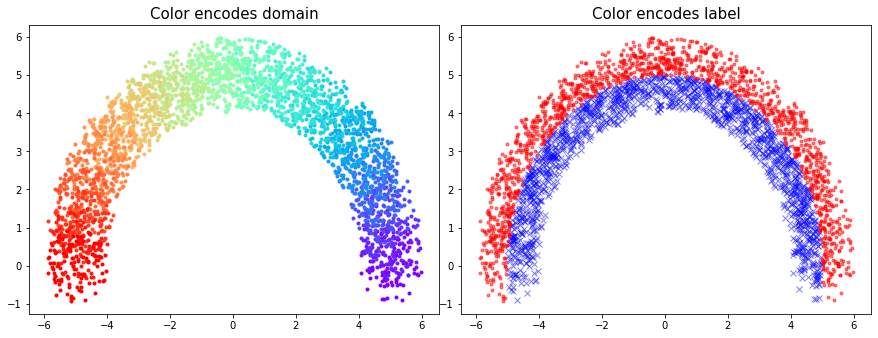

SeqDataset Size 100 Sub Size [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [4]:
from dataset import *
from plot import plot_dataset

# load raw data
data_pkl = read_pickle(f'./data/{opt.data}.pkl')
print(f"Data: {data_pkl['data'].shape}\nLabel: {data_pkl['label'].shape}")
# visualize raw data
plot_dataset(data_pkl)

# build dataset
data = data_pkl['data']
data_mean = data.mean(0, keepdims=True)
data_std = data.std(0, keepdims=True)
data_pkl['data'] = (data - data_mean) / data_std  # normalize the raw data
datasets = [ToyDataset(data_pkl, i, opt) for i in range(opt.num_domain)]  # sub dataset for each domain
dataset = SeqToyDataset(datasets, size=len(datasets[0]))  # mix sub dataset to a large one
dataloader = DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=opt.batch_size
)

In [5]:
%load_ext autoreload
%autoreload 2
from model import get_model

# set random seed (for reproducibility)
np.random.seed(opt.seed)
random.seed(opt.seed)
torch.manual_seed(opt.seed)

# build the model
modelClass = get_model(opt.model)
model = modelClass(opt)
model.to(opt.device)
print(model)

if opt.normalize_domain:
    model.set_data_stats(
        dm=[d.data_m for d in datasets],
        ds=[d.data_s for d in datasets],
    )
    
# train the model
if not opt.continual_da:
    # one-step adaptation
    for epoch in range(opt.num_epoch):
        model.learn(epoch, dataloader)
        if (epoch + 1) % 100 == 0 or (epoch + 1) == opt.num_epoch:
            model.save()
            # model.visualize_D()
            # model.visualize_F()
            # model.visualize_E()
        if (epoch + 1) % 50 == 0:    
            model.test(epoch, dataloader)
else:
    # pretrain on source
    print('===> pretrain the classifer')
    model.prepare_trainer(init=True)
    for epoch in range(opt.num_epoch_pre):
        model.learn(epoch, dataloader, init=True)
        if (epoch + 1) % 10 == 0:
            model.save()
            model.visualize_F()
            model.test(epoch, dataloader)
    # step-by-step domain adapt
    ds_size = len(datasets[0])
    replay_datasets = [datasets[i] for i in range(opt.num_source)]
    print('===> start continual DA')
    model.prepare_trainer(init=False)
    for phase in range(opt.num_source, opt.num_domain):
        continual_dataset = SeqToyDataset(replay_datasets, size=ds_size)
        continual_dataloader = DataLoader(
            dataset=continual_dataset,
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
        )
        model.set_phase(phase)
        for epoch in range(opt.num_epoch_sub):
            model.learn(epoch, (dataloader, continual_dataloader), init=False)
        # model.visualize_F(phase)
        model.save()
        model.test(epoch, dataloader)
        replay_data, replay_label = model.gen_replay_dataset(dataloader)
        replay_datasets.append(ReplayDataset(replay_data, replay_label, opt))

===> Discrinimator Output Activation: identity
CIDA(
  (netE): FeatureNet(
    (fc1): Linear(in_features=2, out_features=800, bias=True)
    (fc2): Linear(in_features=1600, out_features=1600, bias=True)
    (fc3): Linear(in_features=1600, out_features=1600, bias=True)
    (fc4): Linear(in_features=1600, out_features=1600, bias=True)
    (fc_final): Linear(in_features=1600, out_features=800, bias=True)
    (fc1_var): Linear(in_features=1, out_features=800, bias=True)
    (fc2_var): Linear(in_features=800, out_features=800, bias=True)
  )
  (netF): PredNet(
    (fc3): Linear(in_features=800, out_features=800, bias=True)
    (bn3): Identity()
    (fc4): Linear(in_features=800, out_features=800, bias=True)
    (bn4): Identity()
    (fc_final): Linear(in_features=800, out_features=2, bias=True)
  )
  (netD): DiscNet(
    (fc3): Linear(in_features=800, out_features=800, bias=True)
    (bn3): Identity()
    (fc4): Linear(in_features=800, out_features=800, bias=True)
    (bn4): Identity()
    

[Train][319] Loss: D 0.169 E_gan -0.169 E_pred 0.004 E_pseudo 0.000
[Train][319] Accuracy: total average 97.7, in each domain [100. 100. 100. 100. 100. 100.  99.  99. 100.  97.  95.  95.  95.  90.
  95.]
[Train][329] Loss: D 0.174 E_gan -0.174 E_pred 0.012 E_pseudo 0.000
[Train][329] Accuracy: total average 98.4, in each domain [ 99. 100.  99. 100. 100. 100.  99.  99.  98.  98.  98.  99. 100.  95.
  92.]
[Train][339] Loss: D 0.169 E_gan -0.169 E_pred 0.004 E_pseudo 0.000
[Train][339] Accuracy: total average 97.9, in each domain [100. 100. 100. 100. 100. 100.  99.  99.  97.  97.  98.  98.  97.  94.
  90.]
[Train][349] Loss: D 0.173 E_gan -0.173 E_pred 0.006 E_pseudo 0.000
[Train][349] Accuracy: total average 98.4, in each domain [100.  99. 100. 100. 100. 100.  99.  99. 100. 100.  99.  97.  96.  96.
  91.]
[Test][349] Accuracy: total average 98.3, in each domain [100. 100.  99. 100. 100. 100.  99.  99.  99.  99.  99.  97.  96.  96.
  91.]
[Train][359] Loss: D 0.170 E_gan -0.170 E_pred 0.

[Train][669] Loss: D 0.267 E_gan -0.267 E_pred 0.001 E_pseudo 0.002
[Train][669] Accuracy: total average 98.7, in each domain [100. 100. 100. 100. 100. 100.  99.  99. 100.  99.  98.  97.  98.  97.
  94.]
[Train][679] Loss: D 0.267 E_gan -0.267 E_pred 0.001 E_pseudo 0.002
[Train][679] Accuracy: total average 98.7, in each domain [100. 100. 100. 100. 100. 100.  99.  99. 100.  99.  98.  97.  98.  97.
  94.]
[Train][689] Loss: D 0.267 E_gan -0.267 E_pred 0.001 E_pseudo 0.002
[Train][689] Accuracy: total average 98.7, in each domain [100. 100. 100. 100. 100. 100.  99.  99. 100.  99.  98.  97.  98.  97.
  94.]
[Train][699] Loss: D 0.267 E_gan -0.267 E_pred 0.001 E_pseudo 0.002
[Train][699] Accuracy: total average 98.7, in each domain [100. 100. 100. 100. 100. 100.  99.  99. 100.  99.  98.  97.  98.  97.
  94.]
[Test][699] Accuracy: total average 98.7, in each domain [100. 100. 100. 100. 100. 100.  99.  99. 100.  99.  98.  97.  98.  97.
  94.]
[Train][709] Loss: D 0.267 E_gan -0.267 E_pred 0.

(1500, 2)


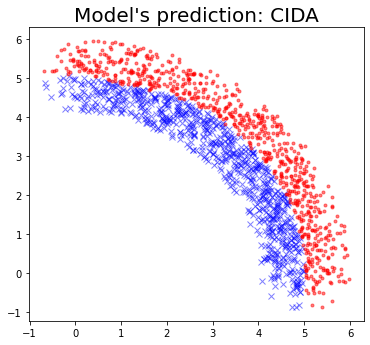

In [6]:
# visualize the model result
from plot import plot_data_and_label
info = read_pickle(opt.outf + '/pred.pkl')
fig, ax = plt.subplots(1, 1, figsize=(6, 6 * 0.9))
print(info['data'].shape)
info['data'] = info['data'] * data_std + data_mean
plot_data_and_label(ax, info['data'], info['label'])
plt.title(f"Model's prediction: {opt.model}", fontsize=20)
plt.show()
